In [1]:
#Import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re, string


from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv(r"C:\Users\HP\Downloads\archive\news.csv")
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
data.rename(columns = {'Unnamed: 0': 'ID'}, inplace = True)

In [4]:
data.shape

(6335, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [6]:
data.iloc[:,1:].describe().T

,count,unique,top,freq
title,6335,6256,OnPolitics | 's politics blog,5
text,6335,6060,"Killing Obama administration rules, dismantlin...",58
label,6335,2,REAL,3171


In [7]:
data.isnull().sum()

ID       0
title    0
text     0
label    0
dtype: int64

In [8]:
#Check duplicates
data.duplicated().sum()

0

In [9]:
data[data.duplicated(subset=['text', 'label'])]

,ID,title,text,label
61,1834,Biden makes another surprise political stop,"On this day in 1973, J. Fred Buzhardt, a lawye...",REAL
90,1661,Exclusive: GOP campaigns plot revolt against RNC,"Killing Obama administration rules, dismantlin...",REAL
157,1329,How Clinton plans to stop Sanders' momentum,"Killing Obama administration rules, dismantlin...",REAL
233,1770,"Scott Walker, Rick Perry show limits of super ...","On this day in 1973, J. Fred Buzhardt, a lawye...",REAL
316,1570,Rand Paul is flatlining,"Killing Obama administration rules, dismantlin...",REAL
...,...,...,...,...
6227,8613,ISIS uses an industrial dough kneader to kill ...,Email \nISIS barbarians used an industrial dou...,FAKE
6233,7171,North Korea Threatens ‘Sacred’ Nuclear War Aga...,Email \nNorth Korea’s Foreign Ministry slammed...,FAKE
6250,2001,Activists bristle at Clinton fundraising,A verdict in 2017 could have sweeping conseque...,REAL
6270,1743,Inside Bernie Sanders’ unorthodox debate prep,"Killing Obama administration rules, dismantlin...",REAL


In [10]:
data = data.drop_duplicates(subset=['text','title'])

In [11]:
data.shape

(6306, 4)

In [12]:
data['label'].value_counts()

REAL    3154
FAKE    3152
Name: label, dtype: int64

In [13]:
data['text'].nunique()

6060

In [14]:
data['title'].nunique()

6256

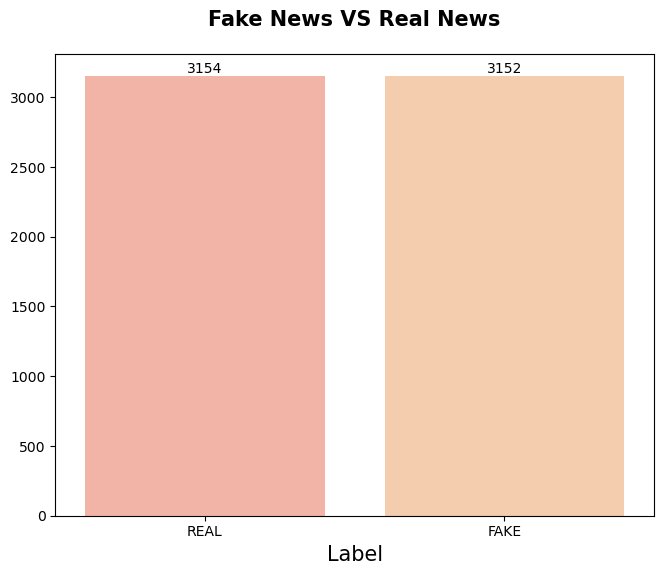

In [15]:
plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
attrition_rate = data["label"].value_counts()
ax=sns.barplot(x=attrition_rate.index,y=attrition_rate.values,palette=['#FFAC9B', '#FFCBA4'])
plt.title("Fake News VS Real News",fontweight="black",size=15,pad=20)
plt.xlabel("Label",size=15)
for i in ax.containers:
    ax.bar_label(i)

Fake and Real News data are balanced.For balanced dataset use Accuracy metric evaluation

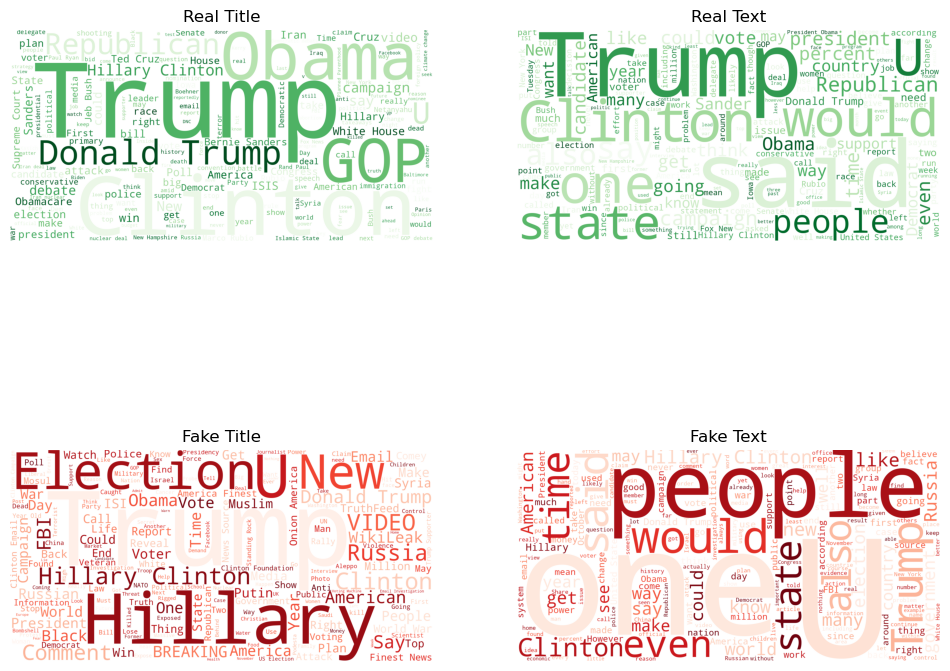

In [16]:
#Wordcloud for Real Title
real_title = ' '.join(data[data['label'] == 'REAL']['title'].astype(str))

wordcloud_rtitle = WordCloud(
    width=2000, height=1000, background_color='white',
    stopwords = stop_words, colormap='Greens',
    min_font_size = 10
).generate(real_title)

#Wordcloud for Real Text
real_text = ' '.join(data[data['label'] == 'REAL']['text'].astype(str))

wordcloud_rtext = WordCloud(
    width=2000, height=1000, background_color='white',
    stopwords = stop_words, colormap='Greens',
    min_font_size = 10
).generate(real_text)

#Wordcloud for Fake Title
fake_title = ' '.join(data[data['label'] == 'FAKE']['title'].astype(str))

wordcloud_ftitle = WordCloud(
    width=2000, height=1000, background_color='white',
    stopwords = stop_words, colormap='Reds',
    min_font_size = 10
).generate(fake_title)

#Wordcloud for Fake Text
fake_text = ' '.join(data[data['label'] == 'FAKE']['text'].astype(str))

wordcloud_ftext = WordCloud(
    width=2000, height=1000, background_color='white',
    stopwords = stop_words, colormap='Reds',
    min_font_size = 10
).generate(fake_text)

plt.figure(figsize=(12, 10)) 
plt.subplot(2,2,1)
plt.imshow(wordcloud_rtitle)
plt.title('Real Title')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(wordcloud_rtext)
plt.title('Real Text')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(wordcloud_ftitle)
plt.title('Fake Title')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(wordcloud_ftext)
plt.title('Fake Text')
plt.axis('off')

plt.show()

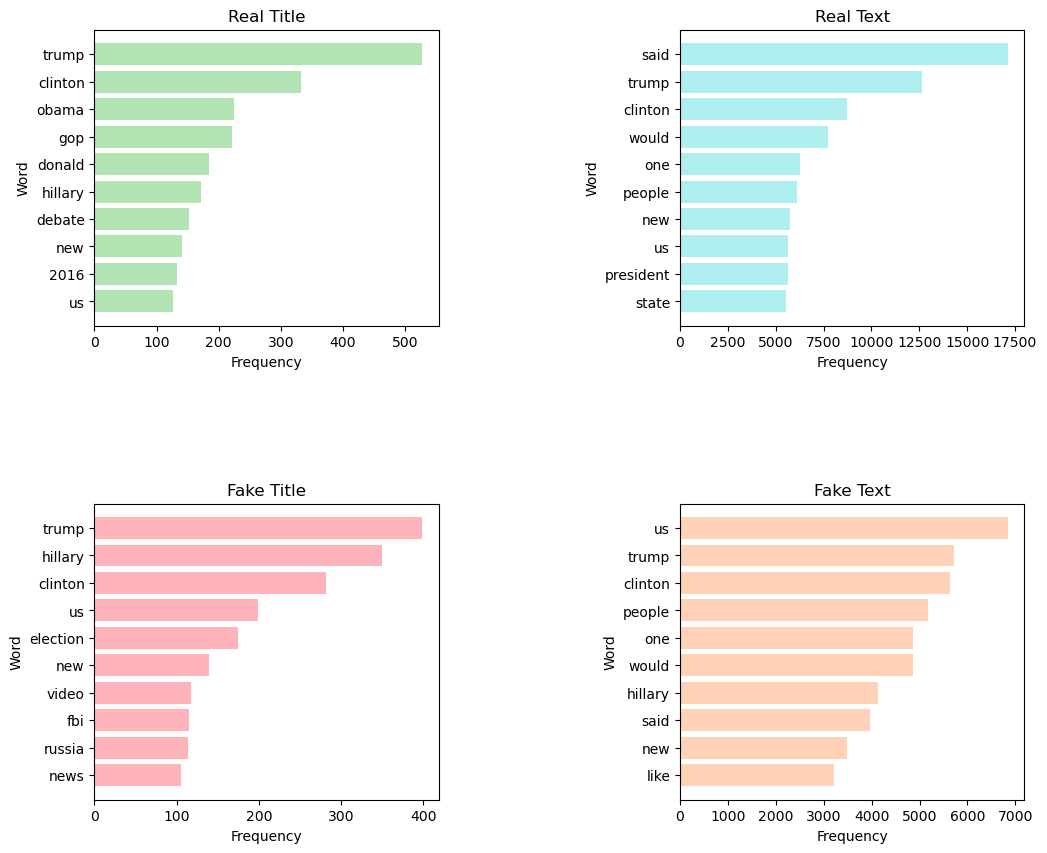

In [17]:
from collections import Counter

#Top 10 Words for Real Title
real_title_count = Counter(word for word in re.sub(r'[^\w\s]', '', real_title.lower()).split() if word not in stop_words)
real_title_top10 = real_title_count.most_common(10)
words1, frequencies1 = zip(*real_title_top10)

#Top 10 Words for Real Text
real_text_count = Counter(word for word in re.sub(r'[^\w\s]', '', real_text.lower()).split() if word not in stop_words)
real_text_top10 = real_text_count.most_common(10)
words2, frequencies2 = zip(*real_text_top10)

#Top 10 Words for Fake Title
fake_title_count = Counter(word for word in re.sub(r'[^\w\s]', '', fake_title.lower()).split() if word not in stop_words)
fake_title_top10 = fake_title_count.most_common(10)
words3, frequencies3 = zip(*fake_title_top10)
#Top 10 Words for Fake Text
fake_text_count = Counter(word for word in re.sub(r'[^\w\s]', '', fake_text.lower()).split() if word not in stop_words)
fake_text_top10 = fake_text_count.most_common(10)
words4, frequencies4 = zip(*fake_text_top10)

plt.figure(figsize=(12, 10))  
plt.subplot(2,2,1)
plt.barh(words1,frequencies1,color='#B2E3B2')
plt.gca().invert_yaxis()
plt.title('Real Title')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.subplot(2,2,2)
plt.barh(words2,frequencies2,color='#AEEEEE')
plt.gca().invert_yaxis()
plt.title('Real Text')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.subplot(2,2,3)
plt.barh(words3,frequencies3,color='#FFB3BA')
plt.gca().invert_yaxis()
plt.title('Fake Title')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.subplot(2,2,4)
plt.barh(words4,frequencies4,color='#FFD2B7')
plt.gca().invert_yaxis()
plt.title('Fake Text')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.subplots_adjust(wspace=0.7, hspace=0.6)
plt.show()

1. Real news have more words.
2. Trump and Clinton consistently appear in both fake and real news.
3. Fake Title tends to have 'sensational' words like FBI, Russia, while Real Title tends to be have more neutral words like debate.

# Data Preprocessing

## Text Cleaning

In [18]:
def clean(text):
    # Remove everything that is not a letter or whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Optionally, convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()  # strip to remove leading/trailing spaces
    return text
data['text_clean']=data['text'].apply(clean)
data['title_clean'] = data['title'].apply(clean)

## Tokenization

In [19]:
data['title_clean'] = data['title_clean'].str.lower()
data['text_clean'] = data['text_clean'].str.lower()

In [20]:
data['title_clean'] = data.apply(lambda row: nltk.word_tokenize(row['title_clean']), axis=1)
data['text_clean'] = data.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1)

## Lemmatization

In [21]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [22]:
def lemmatize_text_spacy(text):
    doc = nlp(" ".join(text))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

In [23]:
data['title_clean'] = data['title_clean'].apply(lemmatize_text_spacy)
data['text_clean'] = data['text_clean'].apply(lemmatize_text_spacy)

In [24]:
data

,ID,title,text,label,text_clean,title_clean
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[daniel, greenfield, a, shillman, journalism, ...","[you, can, smell, hillarys, fear]"
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[google, pinterest, digg, linkedin, reddit, st...","[watch, the, exact, moment, paul, ryan, commit..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,"[us, secretary, of, state, john, f, kerry, say...","[kerry, to, go, to, paris, in, gesture, of, sy..."
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,"[kaydee, king, kaydeeking, november, the, less...","[bernie, supporter, on, twitter, erupt, in, an..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,"[its, primary, day, in, new, york, and, frontr...","[the, battle, of, new, york, why, this, primar..."
...,...,...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,"[the, state, department, tell, the, republican...","[state, department, say, it, can, not, find, e..."
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,"[the, p, in, pbs, should, stand, for, plutocra...","[the, p, in, pbs, should, stand, for, plutocra..."
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,"[antitrump, protester, be, tool, of, the, olig...","[antitrump, protester, be, tool, of, the, olig..."
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,"[addis, ababa, ethiopia, president, obama, con...","[in, ethiopia, obama, seek, progress, on, peac..."


In [25]:
def remove_stopwords_nltk(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(' '.join(text))
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return filtered_text

In [26]:
data['title_clean'] = data['title_clean'].apply(remove_stopwords_nltk)
data['text_clean'] = data['text_clean'].apply(remove_stopwords_nltk)

In [27]:
data

,ID,title,text,label,text_clean,title_clean
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[daniel, greenfield, shillman, journalism, fel...","[smell, hillarys, fear]"
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[google, pinterest, digg, linkedin, reddit, st...","[watch, exact, moment, paul, ryan, commit, pol..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,"[us, secretary, state, john, f, kerry, say, mo...","[kerry, go, paris, gesture, sympathy]"
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,"[kaydee, king, kaydeeking, november, lesson, t...","[bernie, supporter, twitter, erupt, anger, dnc..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,"[primary, day, new, york, frontrunners, hillar...","[battle, new, york, primary, matter]"
...,...,...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL,"[state, department, tell, republican, national...","[state, department, say, find, email, clinton,..."
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,"[p, pbs, stand, plutocratic, pentagon, post, o...","[p, pbs, stand, plutocratic, pentagon]"
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,"[antitrump, protester, tool, oligarchy, reform...","[antitrump, protester, tool, oligarchy, inform..."
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL,"[addis, ababa, ethiopia, president, obama, con...","[ethiopia, obama, seek, progress, peace, secur..."


In [28]:
data['all_title_text'] = data['title_clean'] + data['text_clean']

After all the data is cleaned and processed, now have a data ready to be processed further. I choose to combine both the title and text, and we will use this as our X (independent variable).

In [29]:
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["label"])

In [30]:
data

,ID,title,text,label,text_clean,title_clean,all_title_text
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,"[daniel, greenfield, shillman, journalism, fel...","[smell, hillarys, fear]","[smell, hillarys, fear, daniel, greenfield, sh..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,"[google, pinterest, digg, linkedin, reddit, st...","[watch, exact, moment, paul, ryan, commit, pol...","[watch, exact, moment, paul, ryan, commit, pol..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,"[us, secretary, state, john, f, kerry, say, mo...","[kerry, go, paris, gesture, sympathy]","[kerry, go, paris, gesture, sympathy, us, secr..."
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,"[kaydee, king, kaydeeking, november, lesson, t...","[bernie, supporter, twitter, erupt, anger, dnc...","[bernie, supporter, twitter, erupt, anger, dnc..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,"[primary, day, new, york, frontrunners, hillar...","[battle, new, york, primary, matter]","[battle, new, york, primary, matter, primary, ..."
...,...,...,...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1,"[state, department, tell, republican, national...","[state, department, say, find, email, clinton,...","[state, department, say, find, email, clinton,..."
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0,"[p, pbs, stand, plutocratic, pentagon, post, o...","[p, pbs, stand, plutocratic, pentagon]","[p, pbs, stand, plutocratic, pentagon, p, pbs,..."
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0,"[antitrump, protester, tool, oligarchy, reform...","[antitrump, protester, tool, oligarchy, inform...","[antitrump, protester, tool, oligarchy, inform..."
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1,"[addis, ababa, ethiopia, president, obama, con...","[ethiopia, obama, seek, progress, peace, secur...","[ethiopia, obama, seek, progress, peace, secur..."


## **Vectorization**

The data we have is currently still in text format, while the model needs numerical values, so I need to do vectorization process, which is to convert text to its numeric representatives in vector format.

There are a lot of Vectorization methods, but I decided to use Word2Vec. Word2Vec is a NLP technique used to represent the words in a continuous vector space where the context and meaning of words are mapped. As we are dealing with news, I think semantic meaning is important to be captured, hence the decision to use Word2Vec.

In [31]:
corpus = data['all_title_text'].tolist()

In [32]:
from gensim.models import Word2Vec

word_model = Word2Vec(corpus, min_count=1, workers=5)

In [33]:
def doc_to_vector(document, model):
    word_vectors = [word_model.wv[word] for word in document if word in word_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word_model.vector_size)

X = np.array([doc_to_vector(doc, word_model) for doc in corpus])

In [34]:
X.shape

(6306, 100)

In [35]:
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
classifiers = {"LogisticRegression":LogisticRegression(),
               "KNeighbors":KNeighborsClassifier(),
               "SVC":SVC(),
               "DecisionTree":DecisionTreeClassifier(),
               "RandomForest":RandomForestClassifier(),
               "XGB":XGBClassifier(use_label_encoder=False),
               "LGBM":LGBMClassifier(force_col_wise=True,logging='error',verbose=-1)}

In [37]:
# Dictionary of pipelines and model types for ease of reference
#pipe_dict = {0: "LogisticRegression", 1: "KNeighbors", 2: "SVC",
             #3: "DecisionTree",4: "RandomForest",5: "XGB",6: "LGBM"}

# Cross-validation dan cetak hasilnya
for i, model in classifiers.items():
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (i, cv_score.mean()))

LogisticRegression: 0.876480 
KNeighbors: 0.868751 
SVC: 0.888971 
DecisionTree: 0.795594 
RandomForest: 0.883815 
XGB: 0.893330 
LGBM: 0.889764 


In [38]:
# Melatih semua classifier
for i, cls in classifiers.items():
    cls.fit(X_train, y_train)
    y_pred=cls.predict(X_test)


# Train all classifiers and evaluate on the test set
for i, cls in classifiers.items():
    cls.fit(X_train, y_train)  # Fit the model
    y_pred = cls.predict(X_test)  # Make predictions
    
    # Print confusion matrix and classification report
    print(f"\nResults for {i}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Results for LogisticRegression:
Confusion Matrix:
[[540  64]
 [ 80 578]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       604
           1       0.90      0.88      0.89       658

    accuracy                           0.89      1262
   macro avg       0.89      0.89      0.89      1262
weighted avg       0.89      0.89      0.89      1262


Results for KNeighbors:
Confusion Matrix:
[[517  87]
 [ 67 591]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       604
           1       0.87      0.90      0.88       658

    accuracy                           0.88      1262
   macro avg       0.88      0.88      0.88      1262
weighted avg       0.88      0.88      0.88      1262


Results for SVC:
Confusion Matrix:
[[536  68]
 [ 68 590]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89

# MLFLOW

In [39]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost

In [40]:
# Model parameter grids
param_grids = {
    "LogisticRegression": [{'C':10}],
    "KNeighbors": [{'n_neighbors': 5}],
    "SVC": [{'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}],
    "DecisionTree": [{'max_depth': None}],
    "RandomForest": [{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}],
    "XGB": [{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}],
    "LGBM": [{'n_estimators': 100, 'learning_rate': 0.1}],
                     }

In [41]:
import logging

warnings.filterwarnings("ignore", category=UserWarning, module='mlflow')

# Set logging level to ERROR to suppress warnings
logging.basicConfig(level=logging.ERROR)

# Initialize MLflow
mlflow.set_experiment("Fake_news_prediction")
mlflow.set_tracking_uri("http://localhost:5000")


for model_name, params in param_grids.items():
    for param in params:
        if mlflow.active_run() is not None:
            mlflow.end_run()
            
        # Start a new MLflow run
        with mlflow.start_run(run_name=model_name):
            
            # Initialize the model based on its type
            if model_name == "LogisticRegression":
                model = LogisticRegression(**param)
            elif model_name == "KNeighbors":
                model = KNeighborsClassifier(**param)
            elif model_name == "SVC":
                model = SVC(**param)
            elif model_name == "DecisionTree":
                model = DecisionTreeClassifier(**param)
            elif model_name == "RandomForest":
                model = RandomForestClassifier(**param)
            elif model_name == "XGB":
                model = XGBClassifier(**param, use_label_encoder=False)
            elif model_name == "LGBM":
                model = LGBMClassifier(**param)

            # Fit the model on the training data
            model.fit(X_train, y_train)
             # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Log parameters and metrics to MLflow
            mlflow.log_params(param)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)


            if model_name == "XGB":
                mlflow.xgboost.log_model(model, model_name)
            else:
                mlflow.sklearn.log_model(model, model_name)


2024/10/14 14:49:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\HP\AppData\Local\Temp\tmpo6sm4thb\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/14 14:49:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/14 14:49:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/290999086352108362/runs/02ee22120c754b60b371075299405d27.
2024/10/14 14:49:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/290999086352108362.
2024/10/14 14:49:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:

found out that SVC Model performance is better than other models. Accuracy of svc model is 90.25%

In [42]:
import pickle
# Load the model
with open("svc_model.pkl", "rb") as file:
    svc_model = pickle.load(file)

In [43]:
predictions= model.predict(X_test)

In [44]:
# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')  # Adjust average as needed
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.8969889064976229
Precision: 0.8969789028647245
Recall: 0.8969889064976229
F1 Score: 0.8969816481242947


In [45]:
x_new="They are all 'Treasonous' lying, narcissistical, sociopathic bastards!....When Trump say's they need to 'drain the swamp' or whatever?...he's not wrong, but who's going to have he's back when he's dredging the filth out of the swamp that is political Washington and all the corporate 'skid marks' along with the corrupt Bankster's and especially the FED reserve?....Who?."
x_new

"They are all 'Treasonous' lying, narcissistical, sociopathic bastards!....When Trump say's they need to 'drain the swamp' or whatever?...he's not wrong, but who's going to have he's back when he's dredging the filth out of the swamp that is political Washington and all the corporate 'skid marks' along with the corrupt Bankster's and especially the FED reserve?....Who?."

In [52]:
def fake_news_det(news,word2vec_model):
    # Preprocess the news text
    review = news
    review = re.sub(r'[^a-zA-Z\s]', '', review)  # Remove non-alphabetic characters
    review = review.lower()  # Convert to lowercase

    # Tokenize and lemmatize using spaCy
    doc = nlp(review)  # Process the text with spaCy
    corpus = [token.lemma_ for token in doc if not token.is_stop]  # Lemmatize and filter stop words

    # Convert to Word2Vec input
    vectorized_input_data = [word_model.wv[word] for word in corpus if word in word2vec_model.wv]

    if not vectorized_input_data:  # Check if vectorized input data is empty
        print("No valid words to vectorize.")
        return

    # Average the Word2Vec vectors (or use another method)
    vectorized_input_data = np.mean(vectorized_input_data, axis=0).reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(vectorized_input_data)

    if prediction[0] == 0:
        print("Prediction of the News: Looking Fake⚠ News📰")
    else:
        print("Prediction of the News: Looking Real News📰")


In [60]:
x_news=data['text'][1]
x_news

'Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. Today proved it. \nIn a particularly staggering example of political cowardice, Paul Ryan re-re-re-reversed course and announced that he was back on the Trump Train after all. This was an aboutface from where he was a few weeks ago. He had previously declared he would not be supporting or defending Trump after a tape was made public in which Trump bragged about assaulting women. Suddenly, Ryan was appearing at a pro-Trump rally and boldly declaring that he already sent in his vote to make him President of the United States. It was a surreal moment. The figurehead of the Republican Party dosed himself in gasoline, got up on a stage on a chilly afternoon in Wisconsin, and lit a match. . @SpeakerRyan says he voted for @realDonaldTrump : “Republicans, it is time to come home” ht

In [61]:
fake_news_det(x_news,word_model)

Prediction of the News: Looking Fake⚠ News📰


In [62]:
# Save using Gensim
word_model.save("word2vec_model.bin")

# Load using Gensim
loaded_model = Word2Vec.load("word2vec_model.bin")
